In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv("../data/processed/winequality-red-fe.csv")

X = df.drop("quality", axis=1)
y = df["quality"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11
)

### Tried multiple classical ML models (LR, Ridge, Lasso, ENet, RF, GBM) for baseline evaluation.
    Random Forest consistently outperformed the others, so the final pipeline is built on RF.

In [37]:
linear_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

linear_pipe.fit(X_train, y_train)
preds = linear_pipe.predict(X_test)

print("Linear Regression")
print("MAE:", mean_absolute_error(y_test, preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
print("R2:", r2_score(y_test, preds))


Linear Regression
MAE: 0.4526034215823197
RMSE: 0.543472171185174
R2: 0.4109078325534008


In [38]:
rf_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestRegressor(random_state=11, n_jobs=-1))
])

param_dist = {
    "model__n_estimators": [150, 200, 300, 400],
    "model__max_depth": [None, 8, 10, 12],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4]
}

search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_dist,
    n_iter=20,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

In [39]:
search.fit(X_train, y_train)

best_pipe = search.best_estimator_
rf_preds = best_pipe.predict(X_test)

print("\nRandomForest (tuned)")
print("Best params:", search.best_params_)
print("MAE:", mean_absolute_error(y_test, rf_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, rf_preds)))
print("R2:", r2_score(y_test, rf_preds))


RandomForest (tuned)
Best params: {'model__n_estimators': 300, 'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_depth': None}
MAE: 0.3604008142198932
RMSE: 0.46035911762346937
R2: 0.5773098524771249


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(
    style="whitegrid",
    context="notebook",
    font_scale=0.9
)

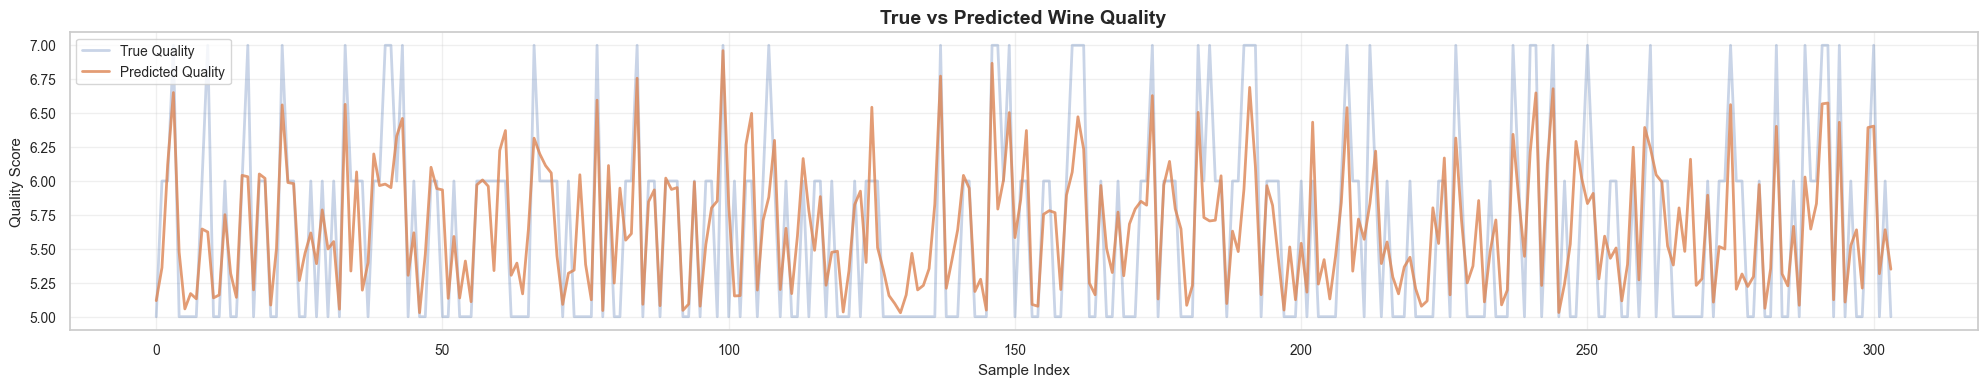

In [41]:
plt.figure(figsize=(20, 4))
plt.plot(y_test.values, label="True Quality", linewidth=2, alpha=0.3,)
plt.plot(rf_preds, label="Predicted Quality", linewidth=2, alpha=0.8)

plt.title("True vs Predicted Wine Quality", fontsize=14, fontweight="bold")
plt.xlabel("Sample Index")
plt.ylabel("Quality Score")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("../visuals/true_vs_predicted_quality.png")
plt.show()
plt.close()

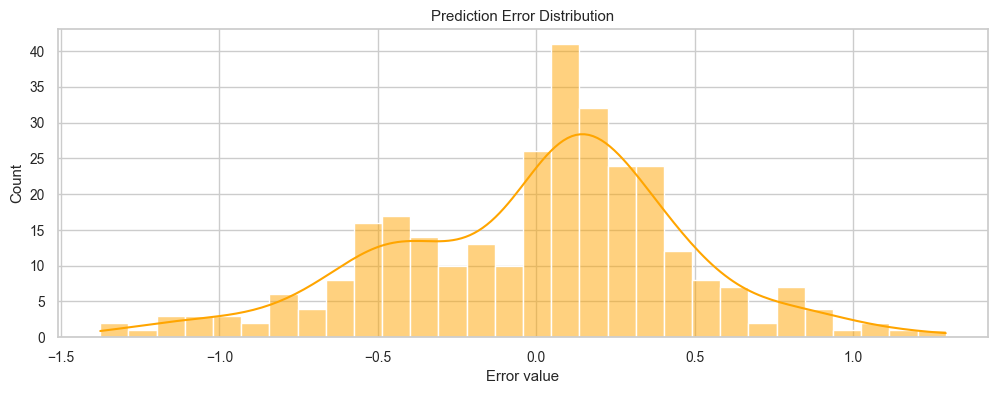

In [42]:
errors = rf_preds - y_test

plt.figure(figsize=(12,4))
sns.histplot(errors, kde=True, color='orange', bins=30)
plt.title("Prediction Error Distribution")
plt.xlabel("Error value")
plt.ylabel("Count")
plt.savefig("../visuals/prediction_error_distribution.png")
plt.show()
plt.close()